<a id='top'></a>

# Rayleigh damping in multi-degree-of-freedom (MDOF) systems

[Introduction](#Introduction)

[Dynamic equilibrium equation](#Dynamic-equilibrium-equation)

[Computational lab](#Computational-lab)

[Mass proportional damping](#Mass-proportional-damping)

[Stiffness proportional damping](#Stiffness-proportional-damping)

[Rayleigh damping](#Rayleigh-damping)

[Example](#Example)

[References](#References)

[Odds and ends](#Odds-and-ends)

## Introduction

In structural dynamics, mass and stiffness can be computed from the geometric characteristics and material properties of a structure but damping can only be estimated based on the fact that structural dynamic responses are, well, [damped](http://www.edwilson.org/BOOK-Wilson/19-DAMP.pdf). It is usually assumed that such damping is viscous, [in the absence of more accurate information](http://www-g.eng.cam.ac.uk/dv_library/Theses/sondiponthesis.pdf), which fits nicely in the solution of the [dynamic equilibrium equation](#Dynamic-equilibrium-equation).

This python notebook will explore the influence of the following special cases in the computation of the dynamic response of MDOF systems:

1. [Mass proportional damping](#Mass-proportional-damping)
2. [Stiffness proportional damping](#Stiffness-proportional-damping)
3. [Rayleigh damping](#Rayleigh-damping)

What makes these cases special is the fact that the damping matrix is orthogonal to the modal matrix and, therefore, it is diagonalizable. This constitutes a clear advantage when it comes to solving the dynamic equilibrium equation system for MDOF systems.

[Back to top](#top)

## Dynamic equilibrium equation

In structural dynamics the second order differential dynamic equilibrium equation can be written in terms of generalized coordinates (d[isplacement]) and their first (v[elocity]) and second (a[cceleration]) time derivatives:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \mathbf{C} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

where:

> $\mathbf{M}$ is the mass matrix  
> $\mathbf{C}$ is the damping matrix  
> $\mathbf{K}$ is the stiffness matrix  
> $\mathbf{a(t)}$ is the acceleration vector  
> $\mathbf{v(t)}$ is the velocity vector  
> $\mathbf{d(t)}$ is the displacement vector  
> $\mathbf{F(t)}$ is the force input vector  

In a MDOF systems all these matrices are of size $NDOF \times NDOF$, where $NDOF$ is the number of generalized degrees of freedom. Carrying out the usual coordinate transformation from generalized coordinates to modal coordinates, $\mathbf{d(t)} = \mathbf{\Phi} \times \mathbf{q(t)}$, and pre-multiplying by the transpose of the modal matrix, $\mathbf{\Phi}^T$, one obtains the following:

\begin{equation}
\mathbf{\Phi}^T \times \mathbf{M} \times \mathbf{\Phi} \times \mathbf{\ddot q(t)} + \mathbf{\Phi}^T \times \mathbf{C} \cdot \mathbf{\Phi} \times \mathbf{\dot q(t)} + \mathbf{\Phi}^T \times \mathbf{K} \times \mathbf{\Phi} \times \mathbf{q(t)} = \mathbf{\Phi}^T \times \mathbf{F(t)}
\end{equation}

where:

> $\mathbf{\Phi}^T \times \mathbf{M} \times \mathbf{\Phi} = \mathbf{M_n}$ is a diagonal matrix (with modal mass in the main diagonal)  
> $\mathbf{\Phi}^T \times \mathbf{K} \times \mathbf{\Phi} = \mathbf{K_n}$ is a diagonal matrix (with modal stiffness in the main diagonal)  
> $\mathbf{\Phi}^T \times \mathbf{F(t)} = \mathbf{F_n(t)}$ is a column vector (with modal excitation functions)  

In what concerns the product $\mathbf{\Phi}^T \times \mathbf{C} \times \mathbf{\Phi}$ it will be a diagonal matrix (with modal damping in the main diagonal) only in certain circunstances. This is achieved when damping is proportional to either the mass or the stiffness or a combination of both, which is usually referred to as [Rayleigh damping](http://www.ejge.com/2003/Ppr0318/Ppr0318.pdf). In its generalised form it is represented by the [Caughey series](http://engweb.swan.ac.uk/~adhikaris/fulltext/conference/ftc27.pdf) (see [References](#References) section for more information):

\begin{equation}
\mathbf{C} = \mathbf{M} \times \sum_{j=0}^{N-1}{\alpha_j \cdot \left[ \mathbf{M}^{-1} \times \mathbf{K} \right]^j}
\end{equation}

When this happens, the previous dynamic equilibrium equation system transforms into a set of $NDOF$ one-degree-of-freedom independent dynamic equilibrium equations (modal equations):

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q(t)} + \mathbf{C_n} \times \mathbf{\dot q(t)} + \mathbf{K_n} \times \mathbf{q(t)} = \mathbf{F_n(t)}
\end{equation}

The $NDOF$ independent modal equilibrium equations can be rewritten as:

\begin{equation}
\mathbf{\ddot q_n(t)} + \mathbf{2 \cdot \zeta_n \cdot \omega_n} \cdot \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \cdot \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

where:

> $\zeta_n$ is the modal damping coefficient of mode $N$  
> $\omega_n$ is the modal angular frequency of mode $N$  
> $a_n(t)$ is the modal excitation of mode $N$  

The solution of these $NDOF$ independent dynamic equilibrium equations will follow the standard procedures for the one-degree-of-freedom case. The final solution for the MDOF system ($d(t)$) is obtained by superposing the $NDOF$ modal solutions $q_n(t)$.

We will look now at three different cases where the damping matrix is diagonalizable.

[Back to top](#top)

## Computational lab

Before proceeding any further, let us set the computational lab for this Python notebook:

In [1]:
import sys
import math
import numpy as np
import matplotlib as mpl
print('System: {}'.format(sys.version))
for package in (np, mpl):
    print('Package: {} {}'.format(package.__name__, package.__version__))

System: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Package: numpy 1.11.2
Package: matplotlib 1.5.3


We will produce some plots based on a frequency range to illustrate the concepts:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

ff = np.linspace(0.01, 6., num=600)
wn = 2.*np.pi*ff

[Back to top](#top)

## Mass proportional damping

Mass proportional damping means that the damping matrix is somehow a multiple of the mass matrix:

\begin{equation}
\mathbf{C} = \alpha \cdot \mathbf{M}
\end{equation}

where $\alpha$ is the constant of mass proportionality. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \alpha \cdot \mathbf{M} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \alpha \cdot \mathbf{M_n} \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \alpha \cdot \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \cdot \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, one obtains

\begin{equation}
\alpha = 2 \cdot \zeta_n \cdot \omega_n \Leftrightarrow \zeta_n = \frac{\alpha}{2 \cdot \omega_n}
\end{equation}

from where it can be seen that the mass proportional damping is a hyperbolic function of the vibration frequency $\omega_n$.

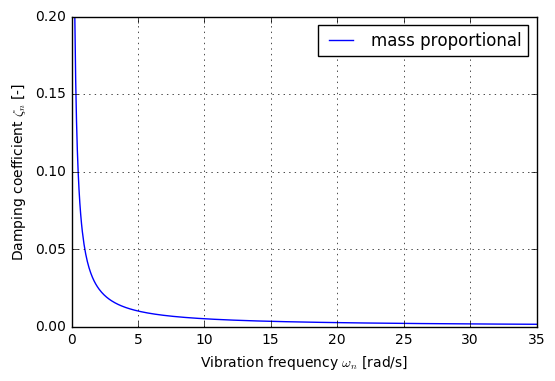

In [3]:
alpha = 0.1
zn_a = alpha/(2.*wn)
plt.plot(wn, zn_a, label='mass proportional')
plt.xlabel('Vibration frequency $\omega_n$ [rad/s]')
plt.ylabel('Damping coefficient $\zeta_n$ [-]')
plt.legend(loc='best')
plt.grid(True)
plt.xlim([0, 35.])
plt.ylim([0, 0.2])
plt.show()

[Back to top](#top)

## Stiffness proportional damping

Stiffness proportional damping means that damping matrix is somehow a multiple of the stiffness matrix:

\begin{equation}
\mathbf{C} = \beta \cdot \mathbf{K}
\end{equation}

where $\beta$ is the constant of stiffness proportionality. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \beta \cdot \mathbf{K} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \beta \cdot \mathbf{K_n} \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \beta \cdot \mathbf{\omega_n^2} \cdot \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \cdot \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, one obtains

\begin{equation}
\beta \cdot \omega_n^2 = 2 \cdot \zeta \cdot \omega_n \Leftrightarrow \zeta_n = \frac{\omega_n \cdot \beta}{2}
\end{equation}

from where it can be seen that the stiffness proportional damping is a linear function of the vibration frequency $\omega_n$.

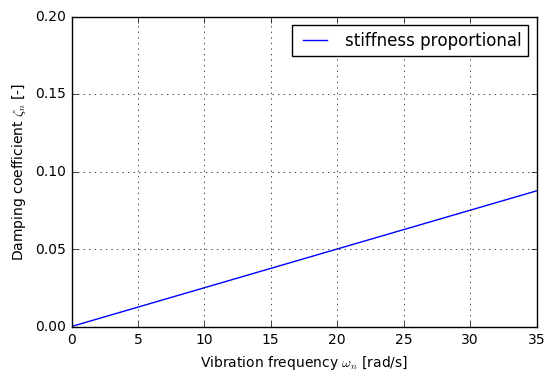

In [4]:
beta = 0.005
zn_b = (beta*wn)/2.
plt.plot(wn, zn_b, label='stiffness proportional')
plt.xlabel('Vibration frequency $\omega_n$ [rad/s]')
plt.ylabel('Damping coefficient $\zeta_n$ [-]')
plt.legend(loc='best')
plt.grid(True)
plt.xlim([0, 35.])
plt.ylim([0, 0.2])
plt.show()

[Back to top](#top)

## Rayleigh damping

When Rayleigh damping is considered it means that the damping coefficient is a combination of the two previous ones, that is, it is a multiple of mass and stifnness:

\begin{equation}
\mathbf{C} = \alpha \cdot \mathbf{M} + \beta \cdot \mathbf{K}
\end{equation}

where $\alpha$ and $\beta$ have the previous meanings. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \left[ \alpha \cdot \mathbf{M} + \beta \cdot \mathbf{K} \right] \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \left[ \alpha \cdot \mathbf{M_n} + \beta \cdot \mathbf{K_n} \right] \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \left[ \alpha + \beta \cdot \mathbf{\omega_n^2} \right] \cdot \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \cdot \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, one obtains

\begin{equation}
\alpha + \beta \cdot \omega_n^2 = 2 \cdot \zeta \cdot \omega_n \Leftrightarrow \zeta_n = \frac{\alpha}{2 \cdot \omega_n} + \frac{\omega_n \cdot \beta}{2}
\end{equation}

from where it can be seen that the Rayleigh damping is the sum of the previous linear and hyperbolic functions of the vibration frequency $\omega_n$.

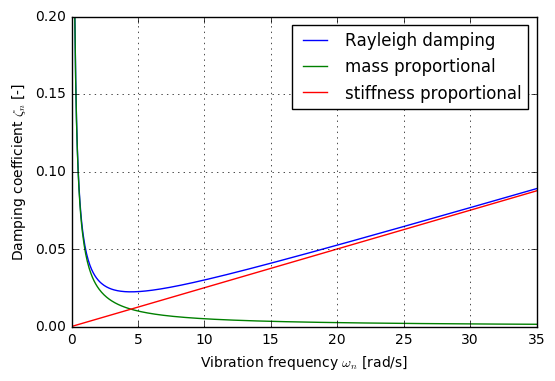

In [5]:
plt.hold(True)
plt.plot(wn, zn_a+zn_b, label='Rayleigh damping')
plt.plot(wn, zn_a, label='mass proportional')
plt.plot(wn, zn_b, label='stiffness proportional')
plt.xlabel('Vibration frequency $\omega_n$ [rad/s]')
plt.ylabel('Damping coefficient $\zeta_n$ [-]')
plt.legend(loc='best')
plt.grid(True)
plt.xlim([0, 35.])
plt.ylim([0, 0.2])
plt.show()

When the Rayleigh damping is used in MDOF systems, the coefficients $\alpha$ and $\beta$ can be computed in order to give an appropriate damping coefficient value for a given frequency range, related to the vibration modes of interest for the dynamic analysis. This is achieved by setting a simple two equation system whose solution yields the values of $\alpha$ and $\beta$:

$$
\left[\begin{array}{cc}
\zeta_1 \\ \zeta_2
\end{array}\right]
=
\left[\begin{array}{cc}
\frac{1}{2 \cdot \omega_1} && \frac{\omega_1}{2} \\ \frac{1}{2 \cdot \omega_2} && \frac{\omega_2}{2}
\end{array}\right]
\times
\left[\begin{array}{cc}
\alpha \\ \beta
\end{array}\right]
$$


[Back to top](#top)

## Example

Let us consider a MDOF system where there are several vibration modes of interest, ranging from 1 to 4 Hz, and that we want compute the dynamic response considering a damping coefficient of 2% for the first mode and 5% for the last mode.

In [6]:
f1, f2 = 1., 4.
z1, z2 = 0.02, 0.05
w1 = 2.*np.pi*f1
w2 = 2.*np.pi*f2
alpha, beta = np.linalg.solve([[1./(2.*w1), w1/2.], [1./(2.*w2), w2/2.]], [z1, z2])
print('Alpha={:.6f}\nBeta={:.6f}'.format(alpha, beta))

Alpha=0.100531
Beta=0.003820


We can check that the Rayleigh damping assumes the required values at the desired frequencies, although may vary considerably for other frequencies:

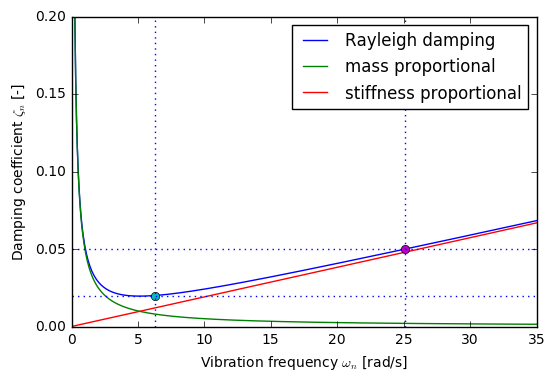

In [7]:
zn_a = alpha/(2.*wn)
zn_b = (beta*wn)/2.
plt.hold(True)
plt.plot(wn, zn_a+zn_b, label='Rayleigh damping')
plt.plot(wn, zn_a, label='mass proportional')
plt.plot(wn, zn_b, label='stiffness proportional')
plt.plot(w1, z1, 'o')
plt.plot(w2, z2, 'o')
plt.axvline(w1, ls=':')
plt.axhline(z1, ls=':')
plt.axvline(w2, ls=':')
plt.axhline(z2, ls=':')
plt.xlabel('Vibration frequency $\omega_n$ [rad/s]')
plt.ylabel('Damping coefficient $\zeta_n$ [-]')
plt.legend(loc='best')
plt.xlim([0, 35.])
plt.ylim([0, 0.2])
plt.show()

[Back to top](#top)

## References

Caughey, T. K. and O’Kelly, M. E. J. (1965). “Classical normal modes in damped linear dynamic systems.” Transactions of ASME, Journal of Applied Mechanics, 32, 583–588.

Clough, Ray W., and Penzien, Joseph, Dynamics of Structures, 2nd ed. (revised), Computers and Structures, 2003.

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)